# Lab 03 - ELE-32

## Alexandre Bellargus e Pedro Igor

### Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Classes Auxiliares

In [2]:
class VNode:
    def __init__(self, index):
        self.index = index
        self.edges = []
        self.value = 0

class CNode:
    def __init__(self, index):
        self.index = index
        self.edges = []
    
class Edge:
    def __init__(self, cnode, vnode):
        self.cnode = cnode
        self.vnode = vnode
        self.val = 0

### LDPC Class

In [3]:
class LDPC:
    def __init__(self, N, dv, dc):
        self.N = N
        self.dv = dv
        self.dc = dc
        self.M = (N*dv)//dc
        self.VNodes = [VNode(i) for i in range(self.N)]
        self.CNodes = [CNode(i) for i in range(self.M)]
        self.H = []
        self.generateLDPCCode()
        self.H = np.array(self.H)
        self.exportHtoCSV()

    def cols_to_rows(self, h):
        h2 = []
        for i in range(len(h[0])):
            h1 = []
            for j in range(len(h)):
                h1.append(h[j][i])
            h2.append(h1)
        return h2

    def generateLDPCCode(self):
        h = self.M//self.dv
        h1 = []
        for i in range(self.N):
            v1 = [0]*h
            v1[i//self.dc] = 1
            h1.append(v1)

        for i in range(self.dv):
            ht = self.cols_to_rows(h1)
            for elem in ht:
                self.H.append(elem)
            # shuffle h collumns
            random.shuffle(h1)
        
        for i in range(self.N):
            for j in range(self.M):
                if(self.H[j][i] == 1):
                    edge = Edge(self.CNodes[j], self.VNodes[i])
                    self.CNodes[j].edges.append(edge)
                    self.VNodes[i].edges.append(edge)

    def exportHtoCSV(self):
        data = []
        for j in range(len(self.H[0])):
            line = []
            for i in range(len(self.H)):
                if(self.H[i][j] == 1):
                    line.append(i+1)
            data.append(line)
        # save as integers
        np.savetxt('H.csv', data, fmt='%i', delimiter=',')

### Canal Gaussiano

In [4]:
class CanalGauss:
    def __init__(self, eb_n0):
        self.sigma2 = 1/(2*eb_n0)
        self.max_iter = 10
    
    def canal(self, v):
        r = []
        for i in range(len(v)):
            if(v[i] == 0):
                v[i] = 1
            else:
                v[i] = -1
            r.append(v[i] + np.random.normal(0, np.sqrt(self.sigma2)))            
        return r
    
    def LLR(self, r):
        L = []
        for i in range(len(r)):
            L.append(2*r[i]/self.sigma2)
        return L

    def beliefPropagation(self, L, Vnodes, Cnodes):
        
        for v in Vnodes:
            for e in v.edges:
                e.val = 0
        for i in range(len(L)):
            Vnodes[i].value = L[i]

        for _ in range(self.max_iter):

            # Vnodes belief propagation
            for vnode in Vnodes:
                sum = vnode.value
                for edge in vnode.edges:
                    sum += edge.val
                for edge in vnode.edges:
                    edge.val = sum - edge.val

            # Stop condition
            if(self.stopCondition(Cnodes)):
                break

            # Cnodes belief propagation
            for cnode in Cnodes:
                min = np.Inf
                second_min = np.Inf
                prod = 1
                for edge in cnode.edges:
                    prod *= edge.val
                    if abs(edge.val) <= min:
                        second_min = min
                        min = abs(edge.val)
                    elif abs(edge.val) < second_min:
                        second_min = abs(edge.val)

                for edge in cnode.edges:
                    if abs(edge.val) == min:
                        edge.val = np.sign(prod * edge.val) * second_min
                    else:
                        edge.val = np.sign(prod *edge.val) * min

        # Decode
        r = []
        for vnode in Vnodes:
            sum = vnode.value
            for edge in vnode.edges:
                sum += edge.val
            r.append(0 if sum >= 0 else 1)

        return r
    
    def stopCondition(self, Cnodes):
        allPositive = True
        for cnode in Cnodes:
            prod = 1
            for edge in cnode.edges:
                prod *= edge.val
            if(prod < 0):
                allPositive = False
                break

        return allPositive

### Aplicação

In [6]:
dbs = [0.5*i for i in range(11)]
n = 1000
ldpc = LDPC(n, 5, 10)

In [7]:
s = 30000
codedErros = []
makeCoded = True
for db in dbs:
    undErr = 0
    decErr = 0
    numWords = int(s*(db+1))
    canalGauss = CanalGauss(10**(db/10))
    for k in range(numWords):
        v = [0]*n
        r = canalGauss.canal(v)
        if makeCoded:
            L = canalGauss.LLR(r)
            o = canalGauss.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
            decErr += sum(o)
        else:
            break
    
    if(decErr == 0):
        makeCoded = False
    codedErros.append(decErr/(n*numWords))
    print("db: ", db, "erro: ", decErr/(n*numWords))

db:  0.0 erro:  0.05931563333333333
db:  0.5 erro:  0.009210577777777777
db:  1.0 erro:  0.00024831666666666664
db:  1.5 erro:  6.133333333333333e-07
db:  2.0 erro:  0.0
db:  2.5 erro:  0.0
db:  3.0 erro:  0.0
db:  3.5 erro:  0.0
db:  4.0 erro:  0.0
db:  4.5 erro:  0.0
db:  5.0 erro:  0.0


In [9]:
s = 1000
undecodedErros = []
for db in dbs:
    undErr = 0
    canalGauss = CanalGauss(10**(db/10))
    for k in range(s):
        v = [0]*n
        r = canalGauss.canal(v)
        c = [0 if r[i] >= 0 else 1 for i in range(len(r))]
        undErr += sum(c)
        
    undecodedErros.append(undErr/(n*s))
    print("db: ", db, "erro: ", undErr/(n*s))

db:  0.0 erro:  0.078473
db:  0.5 erro:  0.067137
db:  1.0 erro:  0.056234
db:  1.5 erro:  0.046242
db:  2.0 erro:  0.037301
db:  2.5 erro:  0.029756
db:  3.0 erro:  0.022915
db:  3.5 erro:  0.017263
db:  4.0 erro:  0.012363
db:  4.5 erro:  0.008915
db:  5.0 erro:  0.005905


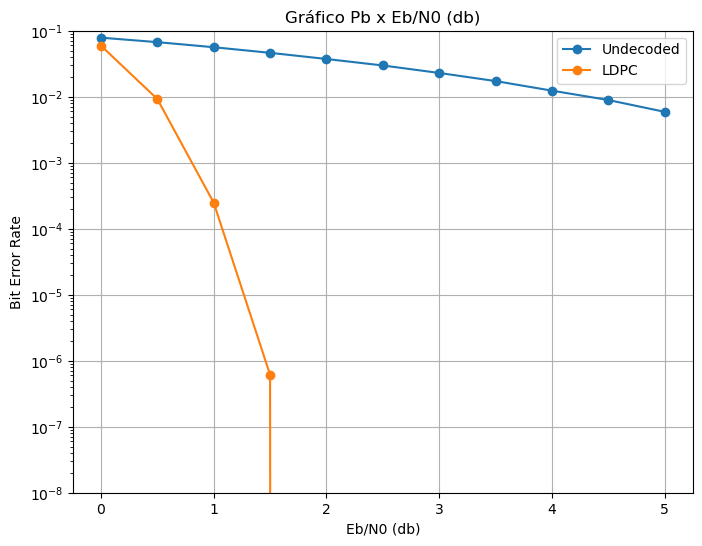

In [10]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(8, 6))

# Plotando os dados
plt.plot(dbs, undecodedErros, marker='o', label='Undecoded')
plt.plot(dbs, codedErros, marker='o', label='LDPC')
plt.yscale("log") 

# Configurando o título e os rótulos dos eixos
plt.title('Gráfico Pb x Eb/N0 (db)')
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Rate')

# Adicionando a legenda
plt.legend()

plt.ylim([0.00000001, 0.1])

# Exibindo o gráfico
plt.grid(True)
plt.show()

#### Maior Valor de E0/N0 que da erro menor que 10^(-4)

Nota-se que o valor deve estar entre 1 e 1.5

In [9]:
s = 10000
dbs = [1.09, 1.1, 1.11, 1.12]
for db in dbs:
    canalGauss = CanalGauss(10**(db/10))
    undErr = 0
    decErr = 0
    for k in range(s):
        v = [0]*n
        r = canalGauss.canal(v)
        L = canalGauss.LLR(r)
        o = canalGauss.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
        decErr += sum(o)    
    
    print("db: ", db, "erro: ", decErr/(n*s))

db:  1.09 erro:  0.000105
db:  1.1 erro:  8.24e-05
db:  1.11 erro:  7.31e-05
db:  1.12 erro:  7.63e-05
